In [65]:
from __future__ import absolute_import,division,print_function,unicode_literals
#importing the necessary libraries and dependencies
import pandas as pd
import numpy as np
import seaborn as sns;
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [66]:
data = pd.read_csv('cleaned_data.csv')
# Convert the date column to datetime
data['From Date'] = data['From Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data['To Date'] = data['To Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data['From Date'].min(), data['From Date'].max()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   From Date  1599 non-null   datetime64[ns]
 1   To Date    1599 non-null   datetime64[ns]
 2   PM2.5      1579 non-null   float64       
 3   PM10       1583 non-null   float64       
 4   NO         1582 non-null   float64       
 5   NO2        1582 non-null   float64       
 6   Nox        1582 non-null   float64       
 7   NH3        1567 non-null   float64       
 8   SO2        1566 non-null   float64       
 9   CO         1580 non-null   float64       
 10  Ozone      1538 non-null   float64       
 11  Benzene    1484 non-null   float64       
 12  Toluene    1484 non-null   float64       
 13  RH         1583 non-null   float64       
 14  WD         1583 non-null   float64       
 15  SR         1583 non-null   float64       
 16  BP         1582 non-null   float64       


In [67]:
aq_df = data.set_index('To Date')
aq_df.drop(['From Date'], axis=1, inplace=True)
aq_df.head()

,PM2.5,PM10,NO,NO2,Nox,NH3,SO2,CO,Ozone,Benzene,Toluene,RH,WD,SR,BP,AT,Xylene,TOT-RF
To Date,,,,,,,,,,,,,,,,,,
2018-11-12,251.16,439.83,1.75,83.25,45.69,39.29,23.07,1.57,39.13,6.70,17.96,76.73,240.05,29.55,992.08,19.86,0.31,0.0
2018-11-13,235.81,340.70,4.97,80.06,46.58,35.29,13.32,1.54,44.63,6.57,13.94,77.34,244.45,107.99,990.39,19.82,0.31,0.0
2018-11-14,285.09,428.91,16.67,111.32,72.80,41.51,21.87,1.34,31.22,8.68,43.54,78.66,219.97,77.29,988.21,20.48,0.91,0.0
2018-11-15,144.36,205.45,6.34,96.49,56.09,35.79,12.56,1.00,41.93,5.64,28.66,77.86,214.38,105.27,989.02,21.22,0.54,1.0
2018-11-16,109.24,154.94,6.91,77.06,46.79,30.92,12.69,0.65,28.81,4.17,33.59,79.27,185.82,112.20,992.52,19.82,0.57,0.0


In [68]:
print(aq_df.shape)
print(aq_df.isna().sum())

(1599, 18)
PM2.5       20
PM10        16
NO          17
NO2         17
Nox         17
NH3         32
SO2         33
CO          19
Ozone       61
Benzene    115
Toluene    115
RH          16
WD          16
SR          16
BP          17
AT          17
Xylene     117
TOT-RF       0
dtype: int64


In [69]:
# fill missing values with a value at the same time one day ago
aq_df.fillna(method='ffill', inplace=True)

In [70]:
aq_df.columns
aq_df.drop(['Nox','Benzene', 'Toluene'], axis=1, inplace=True)

In [71]:
print(aq_df.shape)

(1599, 15)


In [72]:
# define the train and test data
x_train = aq_df[:'2021-12-31']
y_train = x_train['Ozone']
x_test = aq_df['2022-01-01':]
y_test = x_test['Ozone']
print(y_test)

To Date
2022-01-02 00:00:00    14.24
2022-01-03 00:00:00    11.39
2022-01-04 00:00:00    17.99
2022-01-05 00:00:00    14.20
2022-01-06 00:00:00     7.92
                       ...  
2023-03-25 00:00:00    29.68
2023-03-26 00:00:00    54.00
2023-03-27 00:00:00    48.79
2023-03-28 00:00:00    52.68
2023-03-28 11:31:00    26.29
Name: Ozone, Length: 452, dtype: float64


In [73]:
# calculate length of train and test data
train_len = len(x_train)
test_len = len(x_test)
print(train_len / aq_df.shape[0])
print(test_len / aq_df.shape[0]) 

0.7173233270794246
0.28267667292057536


In [74]:
# #Normalizing training data
# train_norm = x_train['Ozone']

# #converted into array as all the methods available are for arrays and not lists
# train_norm_arr = np.asarray(train_norm)
# train_norm = np.reshape(train_norm_arr, (-1, 1))

# #Scaling all values between 0 and 1 so that large values don't just dominate
# scaler = MinMaxScaler(feature_range=(0, 1))
# train_norm = scaler.fit_transform(train_norm)
# for i in range(5):
#     print(train_norm[i])

[0.37549525]
[0.42997227]
[0.29714739]
[0.403229]
[0.27327655]


In [75]:
# count = 0
# for i in range(len(train_norm)):
#     if train_norm[i] == 0:
#         count = count +1
# print('Number of null values in train_norm = ', count)

Number of null values in train_norm =  1


In [76]:
# #removing null values 
# train_norm = train_norm[train_norm!=0]

In [77]:
# #Normalizing testing data and repeating the same process as done for training data
# test_norm = x_test['Ozone']
# test_norm_arr = np.asarray(test_norm)
# test_norm = np.reshape(test_norm_arr, (-1, 1))
# scaler = MinMaxScaler(feature_range=(0, 1))
# test_norm = scaler.fit_transform(test_norm)
# for i in range(5):
#     print(test_norm[i])

[0.11522673]
[0.08801909]
[0.15102625]
[0.11484487]
[0.0548926]


In [78]:
count = 0
for i in range(len(test_norm)):
    if test_norm[i] == 0:
        count = count + 1 
print('Number of null values in test_norm = ', count)

Number of null values in test_norm =  1


In [79]:
#removing null values
test_norm = test_norm[test_norm != 0]

In [80]:
print(train_norm.shape)
print(test_norm.shape)

(1146,)
(451,)


Since this is a time series data, we should be predicting the values after looking at a set of values rather than just a single value like we usually do. This takes into account the correlation between the data points and the timestamps. Because the neighbours should be considered for how the values change over time. Let's define a function to do this.

The below function called split_sequence splits the sequence into sets of n values. This n is given as n_steps (step_size). For example, if n=3, we split the sequence in groups of 3. We create 2 empty lists and append the split sequences.

In [81]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X),array(y)

Here the number of features = 1 as we will be predicting a single value. Let's reshape the split sequences into the format of number of rows, number of columns. (shape[0], shape[1]). In the output, we can see that groups of 3 since n_steps = 3 have been obtained.

In [82]:
n_steps = 15
X_split_train, y_split_train = split_sequence(train_norm, n_steps)
#for i in range(len(X_split_train)):
    #print(X_split_train[i], y_split_train[i])
n_features = 1
X_split_train = X_split_train.reshape((X_split_train.shape[0], X_split_train.shape[1], n_features))
for i in range(5):
    print(X_split_train)

[[[0.37549525]
  [0.42997227]
  [0.29714739]
  ...
  [0.38341918]
  [0.37143423]
  [0.33963946]]

 [[0.42997227]
  [0.29714739]
  [0.403229  ]
  ...
  [0.37143423]
  [0.33963946]
  [0.32151347]]

 [[0.29714739]
  [0.403229  ]
  [0.27327655]
  ...
  [0.33963946]
  [0.32151347]
  [0.28308241]]

 ...

 [[0.15540808]
  [0.15897385]
  [0.10528922]
  ...
  [0.08161648]
  [0.1026149 ]
  [0.05794374]]

 [[0.15897385]
  [0.10528922]
  [0.16174723]
  ...
  [0.1026149 ]
  [0.05794374]
  [0.07706022]]

 [[0.10528922]
  [0.16174723]
  [0.13956022]
  ...
  [0.05794374]
  [0.07706022]
  [0.09538431]]]
[[[0.37549525]
  [0.42997227]
  [0.29714739]
  ...
  [0.38341918]
  [0.37143423]
  [0.33963946]]

 [[0.42997227]
  [0.29714739]
  [0.403229  ]
  ...
  [0.37143423]
  [0.33963946]
  [0.32151347]]

 [[0.29714739]
  [0.403229  ]
  [0.27327655]
  ...
  [0.33963946]
  [0.32151347]
  [0.28308241]]

 ...

 [[0.15540808]
  [0.15897385]
  [0.10528922]
  ...
  [0.08161648]
  [0.1026149 ]
  [0.05794374]]

 [[0.158

You can see below that, we predict the value for the first 3 values, then consider that output as one of the 3 values in the next set. For example, we preedict 0.1 first, then we take that 0.1 as input in the second set and so on.

In [83]:
X_split_test, y_split_test = split_sequence(test_norm, n_steps)
for i in range(5):
    print(X_split_test[i], y_split_test[i])
n_features = 1
X_split_test = X_split_test.reshape((X_split_test.shape[0], X_split_test.shape[1], n_features))


[0.11522673 0.08801909 0.15102625 0.11484487 0.0548926  0.07885442
 0.08267303 0.21804296 0.21804296 0.21804296 0.11312649 0.06071599
 0.05966587 0.03866348 0.07646778] 0.042863961813842485
[0.08801909 0.15102625 0.11484487 0.0548926  0.07885442 0.08267303
 0.21804296 0.21804296 0.21804296 0.11312649 0.06071599 0.05966587
 0.03866348 0.07646778 0.04286396] 0.06090692124105013
[0.15102625 0.11484487 0.0548926  0.07885442 0.08267303 0.21804296
 0.21804296 0.21804296 0.11312649 0.06071599 0.05966587 0.03866348
 0.07646778 0.04286396 0.06090692] 0.04668257756563246
[0.11484487 0.0548926  0.07885442 0.08267303 0.21804296 0.21804296
 0.21804296 0.11312649 0.06071599 0.05966587 0.03866348 0.07646778
 0.04286396 0.06090692 0.04668258] 0.07312649164677805
[0.0548926  0.07885442 0.08267303 0.21804296 0.21804296 0.21804296
 0.11312649 0.06071599 0.05966587 0.03866348 0.07646778 0.04286396
 0.06090692 0.04668258 0.07312649] 0.07723150357995227


Let's define our neural network (LSTM: Long Short Term Memory). Let's add 50 nodes in our first layer with a ReLU (Rectified linear unit) activation. Their shape will be step size, number of features. Then we will add, a dense layer with one node for the output.

We can try out different optimizers to see which minimizes loss and maximizes accuracy. Stochastic gradient descent (SGD), Adam, AdaBoost, RMSProp are few of them. lr = learning rate, decay = by how much to decay the learning rate, momentum = how much should the gradient descent be accelerated to dampen oscillations, nesterov = whether to use nesterov momentum. Nesterov has stronger convergence for convex functions. And then we compile using MSE (mean squared loss) as our loss function.

In [140]:
from keras.layers import Bidirectional, LSTM, Dense,LeakyReLU, Dropout, BatchNormalization
from keras.models import Sequential
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
# add one or more hidden layers with leaky relu activation function and dropout
model.add(Dense(50, activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(50, activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(50, activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))
# add output layer
model.add(Dense(1))

#sgd = optimizers.SGD(lr=0.001, decay=1e-5, momentum=1.0, nesterov=False)
sgd = optimizers.SGD(lr=0.01, decay=1e-5, momentum=0.9, nesterov=True) #good

# keras.optimizers.RMSprop(learning_rate=0.01, rho=0.9)
# keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
from sklearn.metrics import r2_score
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [141]:
# fit model
hist = model.fit(X_split_train, y_split_train, validation_data=(X_split_test, y_split_test), epochs=50, verbose = 1)


Epoch 1/50
36/36 [==============================] - 2s 20ms/step - loss: 0.0587 - mae: 0.1859 - val_loss: 0.0198 - val_mae: 0.1114
Epoch 2/50
36/36 [==============================] - 0s 12ms/step - loss: 0.0192 - mae: 0.1084 - val_loss: 0.0141 - val_mae: 0.0789
Epoch 3/50
36/36 [==============================] - 0s 13ms/step - loss: 0.0146 - mae: 0.0897 - val_loss: 0.0128 - val_mae: 0.0735
Epoch 4/50
36/36 [==============================] - 0s 13ms/step - loss: 0.0132 - mae: 0.0836 - val_loss: 0.0122 - val_mae: 0.0723
Epoch 5/50
36/36 [==============================] - 0s 13ms/step - loss: 0.0140 - mae: 0.0860 - val_loss: 0.0123 - val_mae: 0.0744
Epoch 6/50
36/36 [==============================] - 0s 12ms/step - loss: 0.0122 - mae: 0.0806 - val_loss: 0.0123 - val_mae: 0.0738
Epoch 7/50
36/36 [==============================] - 0s 12ms/step - loss: 0.0125 - mae: 0.0796 - val_loss: 0.0120 - val_mae: 0.0679
Epoch 8/50
36/36 [==============================] - 0s 13ms/step - loss: 0.0117 - m

In [142]:
yhat = model.predict(X_split_test)
for i in range(5):
    print(yhat[i])

14/14 [==============================] - 0s 4ms/step
[0.10159171]
[0.08786428]
[0.09190615]
[0.08619493]
[0.09564202]


In [143]:
for i in range(5):
    print(y_split_test[i])

0.042863961813842485
0.06090692124105013
0.04668257756563246
0.07312649164677805
0.07723150357995227


In [144]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_split_test, yhat)
print('MSE: %.5f' % mse)
rmse = sqrt(mse)
print('RMSE: %.5f' % rmse)
r2 = r2_score(y_split_test, yhat)
print('R2: %.5f' % r2)

MSE: 0.01092
RMSE: 0.10452
R2: 0.63687


In [145]:
_, train_acc = model.evaluate(X_split_train, y_split_train, verbose=0)
_, test_acc = model.evaluate(X_split_test, y_split_test, verbose=0)
print('Train: %.5f, Test: %.5f' % (train_acc, test_acc))

Train: 0.06787, Test: 0.06609


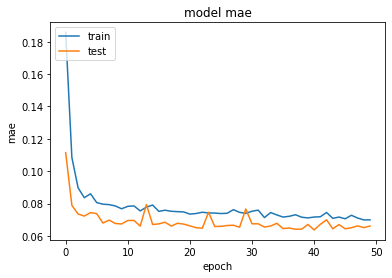

In [146]:
# summarize history for accuracy
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

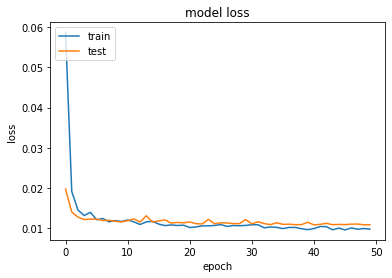

In [147]:
# Above, accuracy increase a lot in the last few epochs. Below, the loss gradually decrease. These are positive signs that our model is doing very good.

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Until now, we just ran our model for prediction of a single pollutant. We have 6 pollutants in our dataset and can make predictions for all of them. So, I have made a function which can be used to predict the other pollutants rather than having to write the code again and again. I have commented the function calls. You can fork this kernel to uncomment and predit the other pollutants (Coz it would take up a lot of space and time).

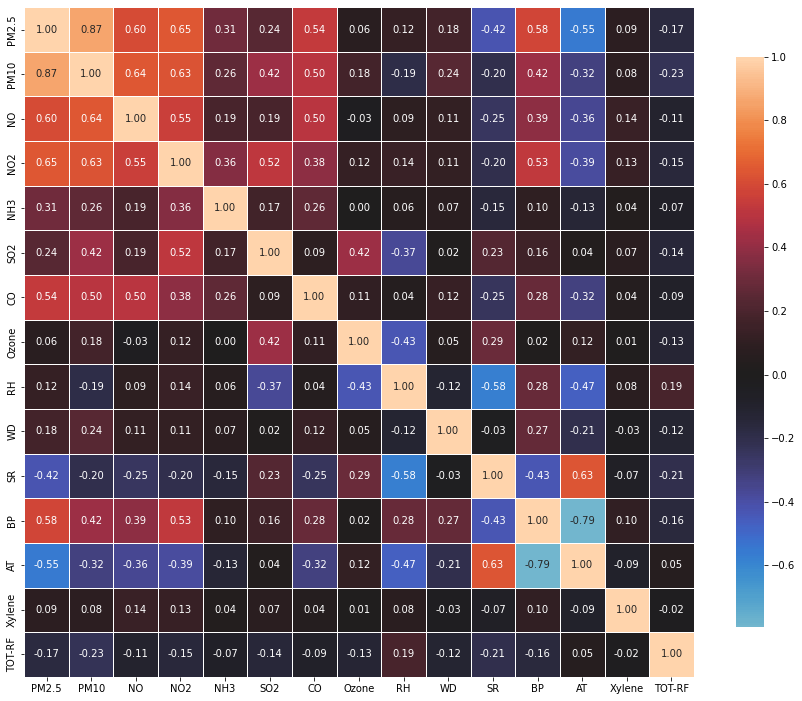

In [148]:
correlations = aq_df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

# bidirectional lstm

In [149]:
from keras.layers import Bidirectional, LSTM, Dense,LeakyReLU, Dropout, BatchNormalization
from keras.models import Sequential

# define model
B_model = Sequential()
B_model.add(Bidirectional(LSTM(128, activation='relu', input_shape=(n_steps, n_features))))
B_model.add(Dense(1))


# compile model
B_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# fit model
B_model.fit(X_split_train, y_split_train, epochs=80, batch_size=64, validation_data=(X_split_test, y_split_test))

Epoch 1/80


In [ ]:
B_yhat = B_model.predict(X_split_test)
for i in range(5):
    print(B_yhat[i])
    print(y_split_test[i])

14/14 [==============================] - 0s 6ms/step
[0.08212055]
0.042863961813842485
[0.06362986]
0.06090692124105013
[0.07157908]
0.04668257756563246
[0.06223499]
0.07312649164677805
[0.07477303]
0.07723150357995227


In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_split_test, B_yhat)
print('MSE: %.5f' % mse)
rmse = sqrt(mse)
print('RMSE: %.5f' % rmse)
# R2 score
r2 = r2_score(y_split_test, B_yhat)
print('R2: %.5f' % r2)

MSE: 0.01202
RMSE: 0.10964
R2: 0.60042


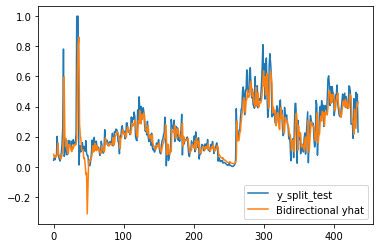

In [ ]:
# plot yhat and y_split_test
plt.plot(y_split_test, label='y_split_test')
plt.plot(B_yhat, label='Bidirectional yhat')
plt.legend()

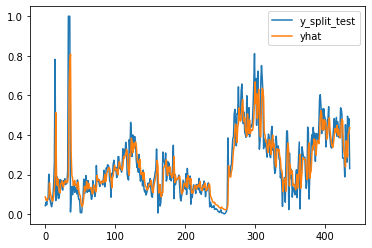

In [ ]:
plt.plot(y_split_test, label='y_split_test')
plt.plot(yhat, label='yhat')
plt.legend()
